# Purpose of the Code

The goal of this notebook is to perform feature selection and evaluate the performance of various machine learning models, identifying the optimal combination of features and models to improve predictive performance and reduce model complexity.

## Environment Setup

In [1]:
import os
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import  KFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from libemg.feature_selector import FeatureSelector

In [4]:
suffixes = ['_channel_1', '_channel_2', '_channel_3', '_channel_4', '_channel_5', '_channel_6', '_channel_7', '_channel_8']
preferred_features = ['MAV', 'SSC', 'WL']
threshold = 0.8  # Correlation threshold
all_high_corr = []
results = []
n_folds = 5

# Paths for input and output
input_folder = '../data/extracted_features/myo/S01_05_26/'  # Input folder with raw data

# Loading Data Files

In [5]:
csv_files = [file for file in os.listdir(input_folder) if file.endswith('.csv')]
df = pd.read_csv(os.path.join(input_folder, csv_files[0]))
df.head()

IAV_channel_1  ISD_channel_1  KURT_channel_1  LD_channel_1  MAV_channel_1  \
0       0.879827       0.020307        3.244875      1.021984       0.021996   
1       1.159809       0.034071        2.395240      1.028990       0.028995   
2       1.334158       0.044635        2.414062      1.033352       0.033354   
3       1.416174       0.050167        2.538440      1.035404       0.035404   
4       1.409435       0.049684        2.488792      1.035236       0.035236   

   MNF_channel_1  MNP_channel_1  MPK_channel_1  RMS_channel_1  \
0       8.978268       0.000020       0.030250       0.022532   
1       7.912735       0.000034       0.033274       0.029185   
2       8.168210       0.000045       0.036458       0.033405   
3       7.817379       0.000051       0.036458       0.035414   
4       8.121113       0.000050       0.036458       0.035243   

   SAMPEN_channel_1  ...  RMS_channel_8  SAMPEN_channel_8  SKEW_channel_8  \
0          0.001111  ...       0.012107          0.001111       -0.287248   
1          0.017784  ...       0.018354          0.068012       -0.164489   
2          0.001111  ...       0.019928          0.001111        0.340546   
3          0.272461  ...       0.018816          0.019002        0.219492   
4          0.001111  ...       0.017281          0.001111       -0.323690   

   SM_channel_8  SSC_channel_8  VAR_channel_8  WAMP_channel_8  WL_channel_8  \
0      0.303941             22   3.803403e-05               0      0.020836   
1      0.358992             25   1.013952e-05               0      0.011043   
2      0.558138             25   2.939701e-07               0      0.001832   
3      0.487573             25   5.945206e-07               0      0.002602   
4      0.421934             28   1.079044e-06               0      0.003510   

   ZC_channel_8      label  
0            20  no weight  
1            23  no weight  
2            24  no weight  
3            22  no weight  
4            23  no weight  

[5 rows x 137 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Columns: 137 entries, IAV_channel_1 to label
dtypes: float64(112), int64(24), object(1)
memory usage: 2.1+ MB


In [7]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the DataFrame
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42) # Split into train (70%), validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Train set:", train_df.shape)
print("Validation set:", val_df.shape)
print("Test set:", test_df.shape)

Train set: (1418, 137)
Validation set: (304, 137)
Test set: (304, 137)


# Exploratory Data Analysis (EDA)

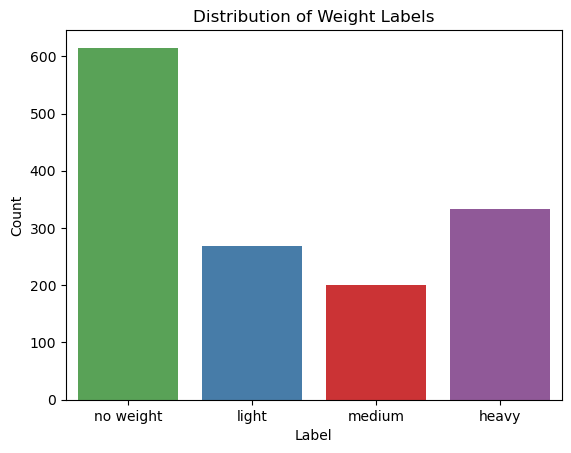

In [8]:
temp = train_df.copy()
ax = sns.countplot(data=temp, x='label', hue='label', order=['no weight', 'light', 'medium', 'heavy'], palette='Set1', legend=False)
ax.set_title('Distribution of Weight Labels')
ax.set_xlabel('Label')
ax.set_ylabel('Count') 
plt.show()

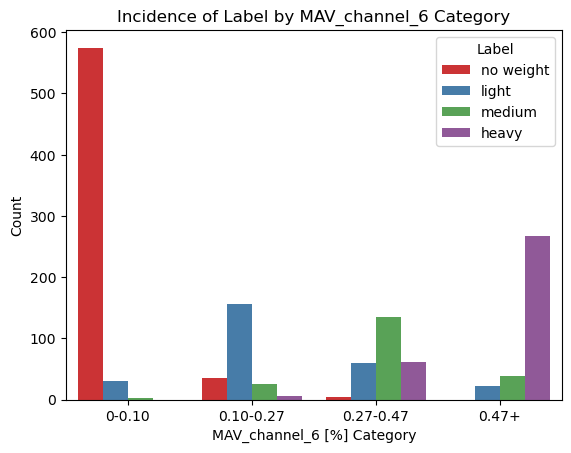

In [13]:
bins = [0, 0.10, 0.27, 0.47, np.inf]
labels = ['0-0.10', '0.10-0.27', '0.27-0.47', '0.47+']
temp['MAV_channel_6_cat'] = pd.cut(temp['MAV_channel_6'], bins=bins, labels=labels, right=False)

ax = sns.countplot(data=temp, x='MAV_channel_6_cat', hue='label', palette='Set1', order=labels, 
                   hue_order=['no weight', 'light', 'medium', 'heavy'])
plt.legend(title='Label', loc='upper right')
plt.title('Incidence of Label by MAV_channel_6 Category')
plt.xlabel('MAV_channel_6 [%] Category')
plt.ylabel('Count')

plt.show()

# Feature Engineering

## Feature Correlation Selection

In [14]:
X = train_df.drop(columns=['label'])
y = train_df['label']

In [15]:
label_map = {'no weight': 0, 'light': 1, 'medium': 2, 'heavy': 3}
y = y.map(label_map)

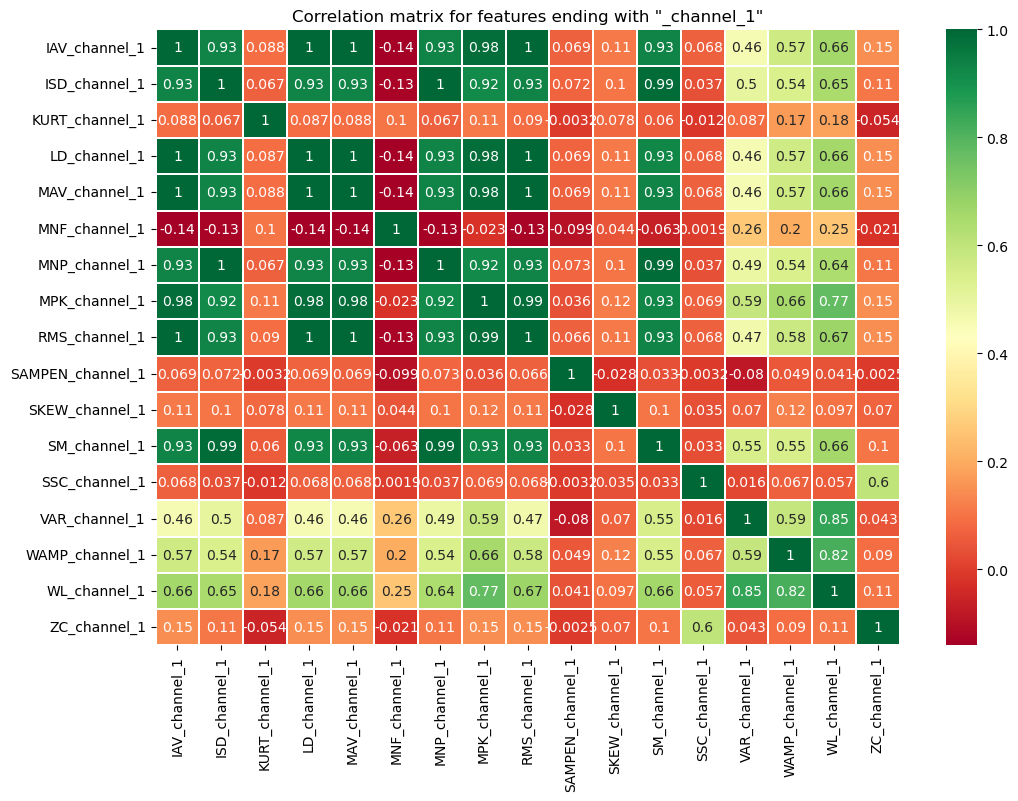

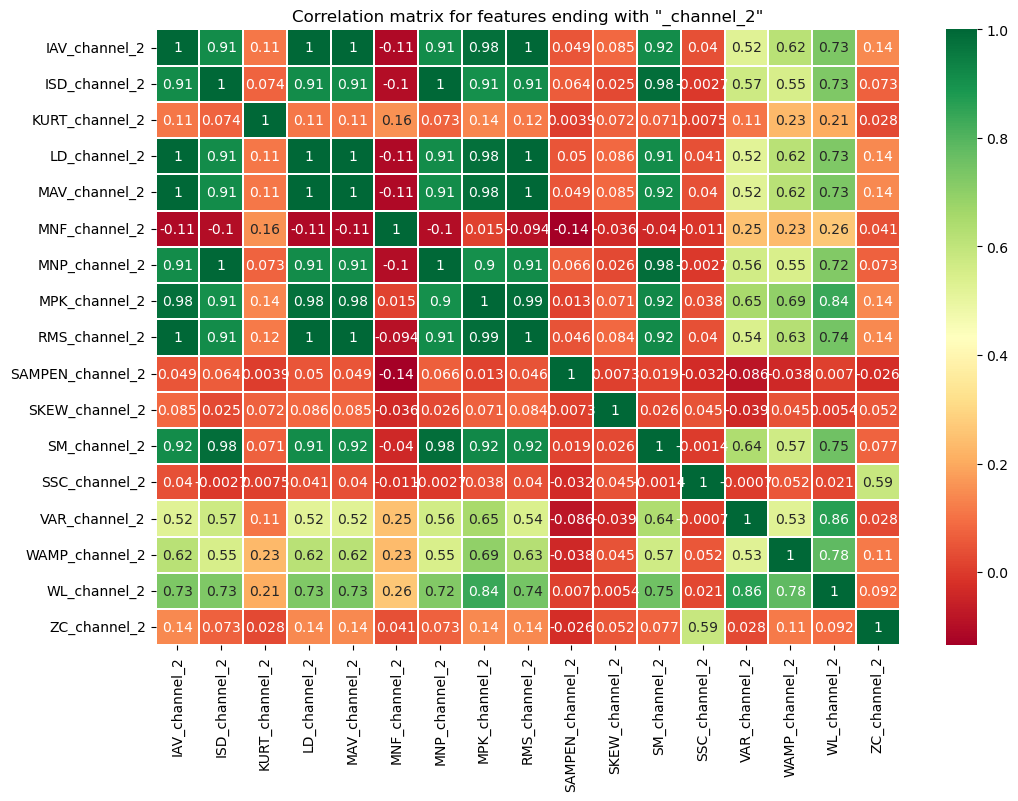

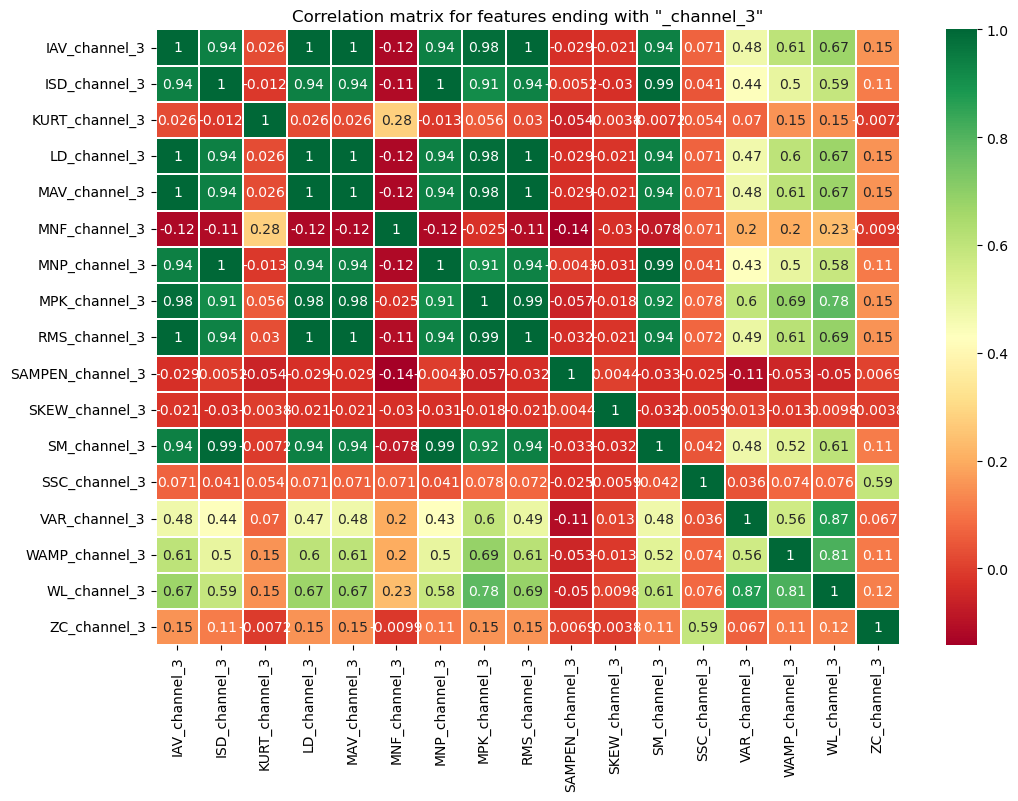

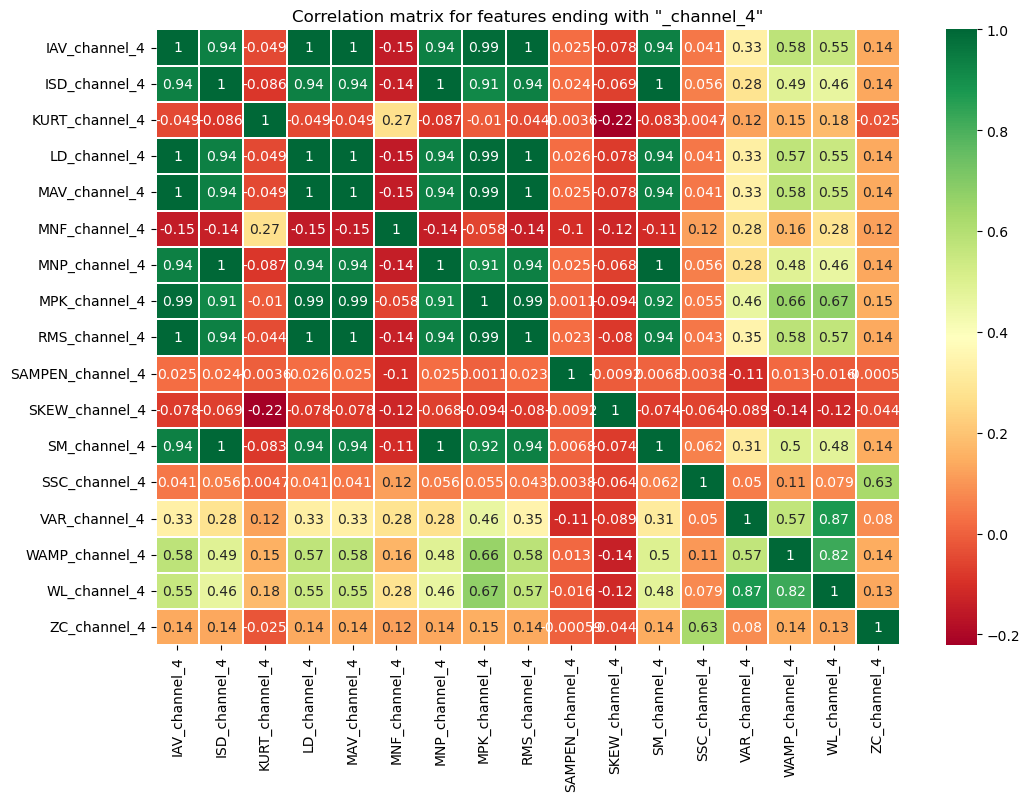

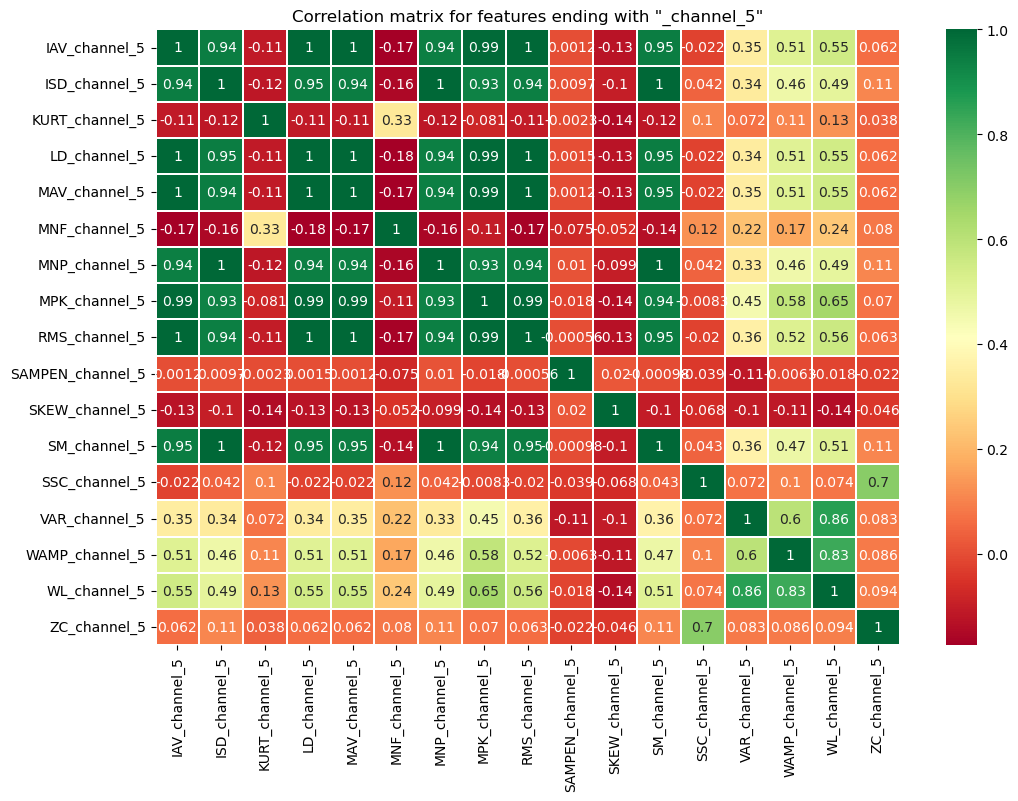

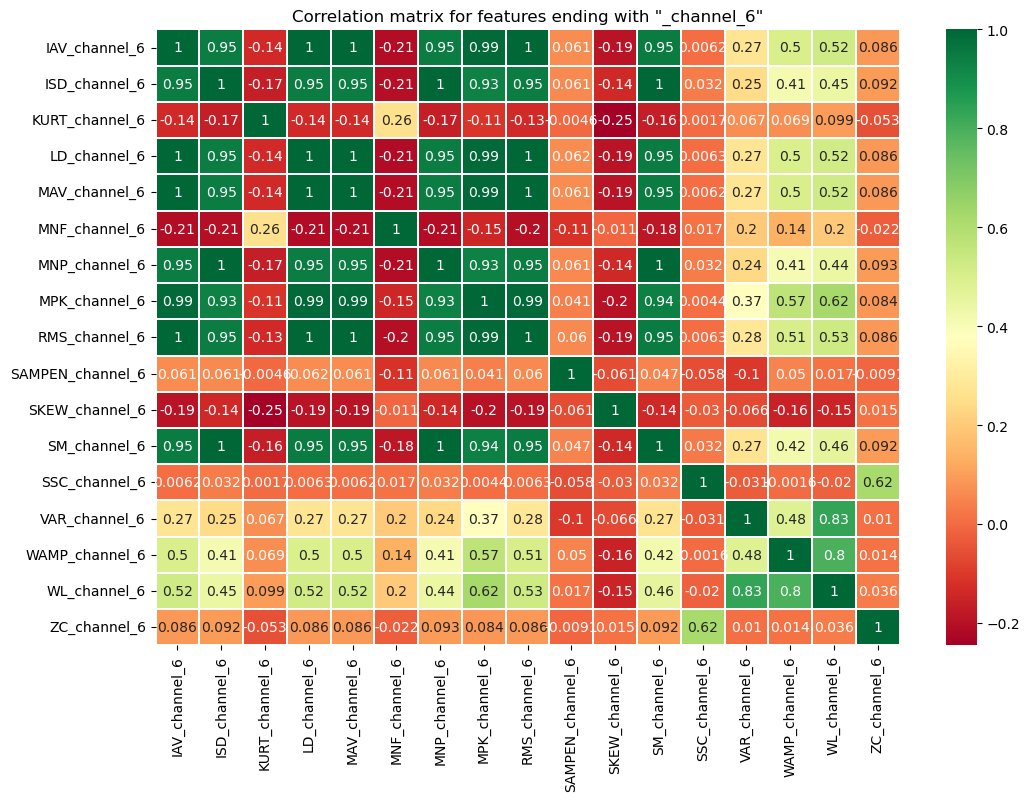

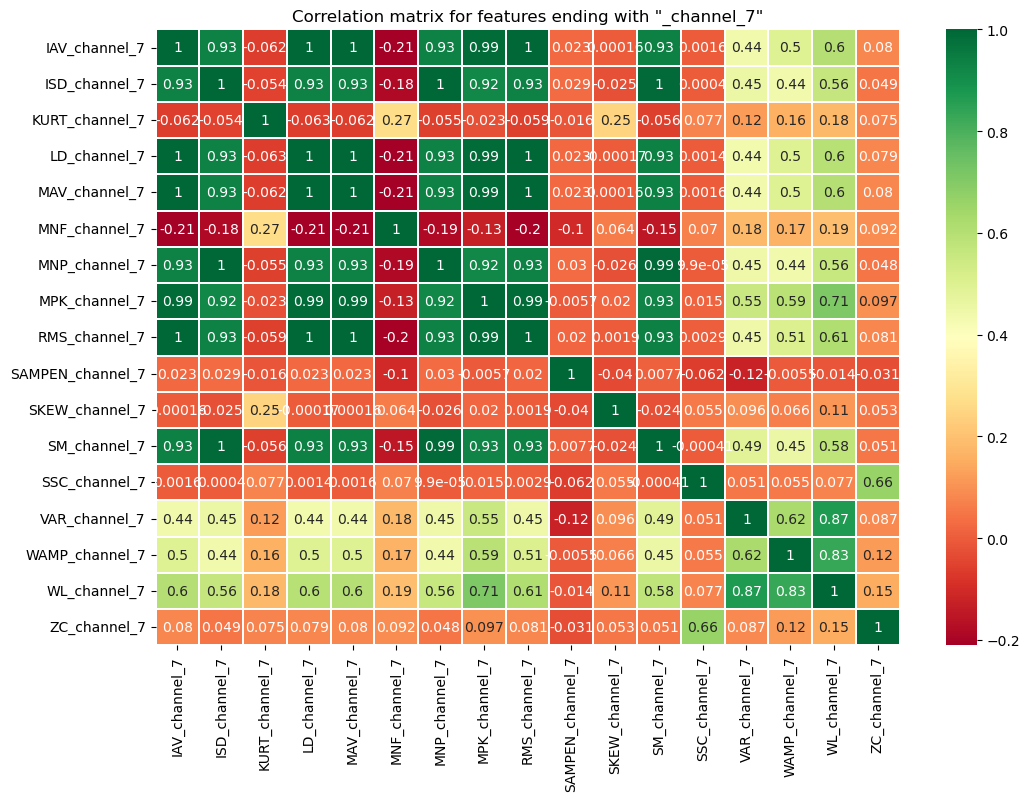

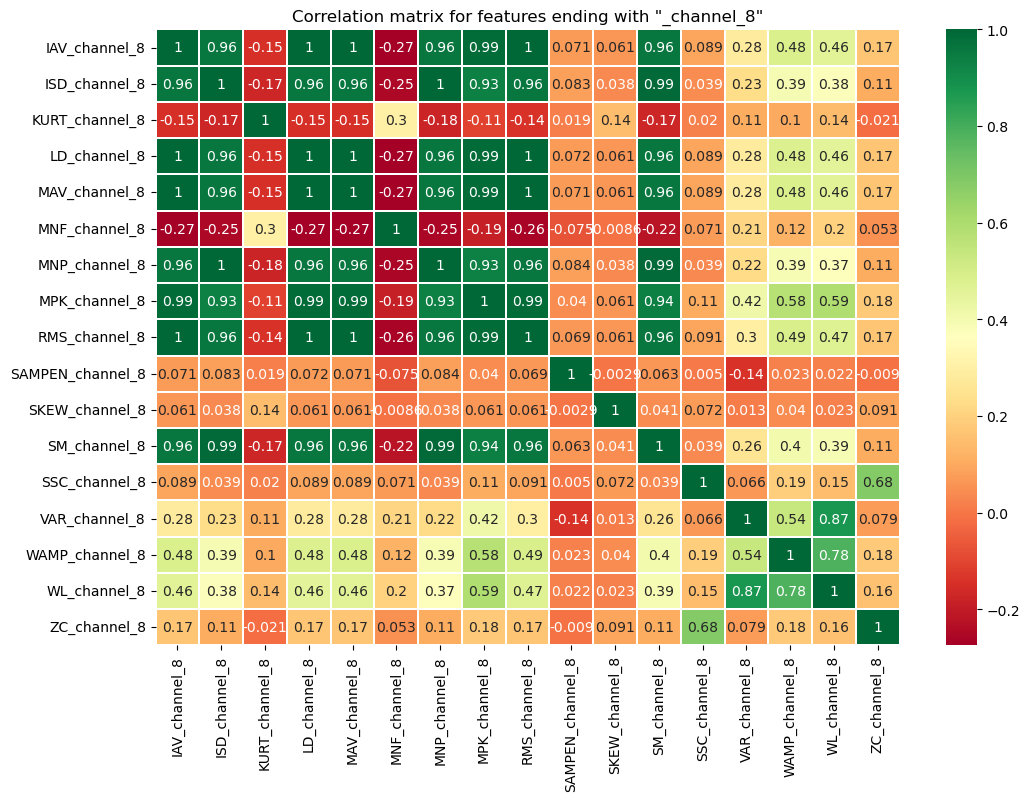

In [16]:
for suffix in suffixes:
    cols = [col for col in X.columns if col.endswith(suffix)]

    subset = X[cols]

    plt.figure(figsize=(12, 8))
    sns.heatmap(subset.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
    plt.title(f'Correlation matrix for features ending with "{suffix}"')
    plt.show()

In [17]:
# Loop through each muscle group or signal subset
for suffix in suffixes:
    # Find all columns in this group
    cols = [col for col in X.columns if col.endswith(suffix)]
    subset = X[cols]

    # Compute correlation matrix (absolute values)
    corr_matrix = subset.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Determine the full list of preferred features to keep for this group
    features_to_keep = [f + suffix for f in preferred_features if f + suffix in subset.columns]

    # Initialize a set to collect features to drop
    features_to_drop = set()

    # For each feature to keep, drop all other features that are highly correlated with it
    for keep_feat in features_to_keep:
        if keep_feat in upper.columns:
            # Find features with correlation > threshold and not in the keep list
            correlated = [
                col for col in upper.columns 
                if col != keep_feat and corr_matrix.loc[keep_feat, col] > threshold and col not in features_to_keep
            ]
            features_to_drop.update(correlated)

    # Drop features from main DataFrame
    X = X.drop(columns=list(features_to_drop))

# Final correlation check to print remaining correlations > 0.8
print("Remaining highly correlated features (>0.8) after filtering with MAV, SSC, WL:")

for suffix in suffixes:
    cols = [col for col in X.columns if col.endswith(suffix)]
    subset = X[cols]
    
    corr_matrix = subset.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    high_corr = [
        (suffix, col, row, corr_matrix.loc[row, col]) 
        for col in upper.columns 
        for row in upper.index 
        if upper.loc[row, col] > threshold
    ]
    
    all_high_corr.extend(high_corr)

if not all_high_corr:
    print("No high correlations found in any subset.")
else:
    for suffix in suffixes:
        suffix_corrs = [item for item in all_high_corr if item[0] == suffix]
        if suffix_corrs:
            print(f'\nSubset "{suffix}":')
            for _, feat1, feat2, corr_val in suffix_corrs:
                print(f'  {feat1} and {feat2} are correlated with {corr_val:.2f}')

Remaining highly correlated features (>0.8) after filtering with MAV, SSC, WL:
No high correlations found in any subset.


In [18]:
print(f"\nTotal remaining features: {len(X.columns)}")


Total remaining features: 67


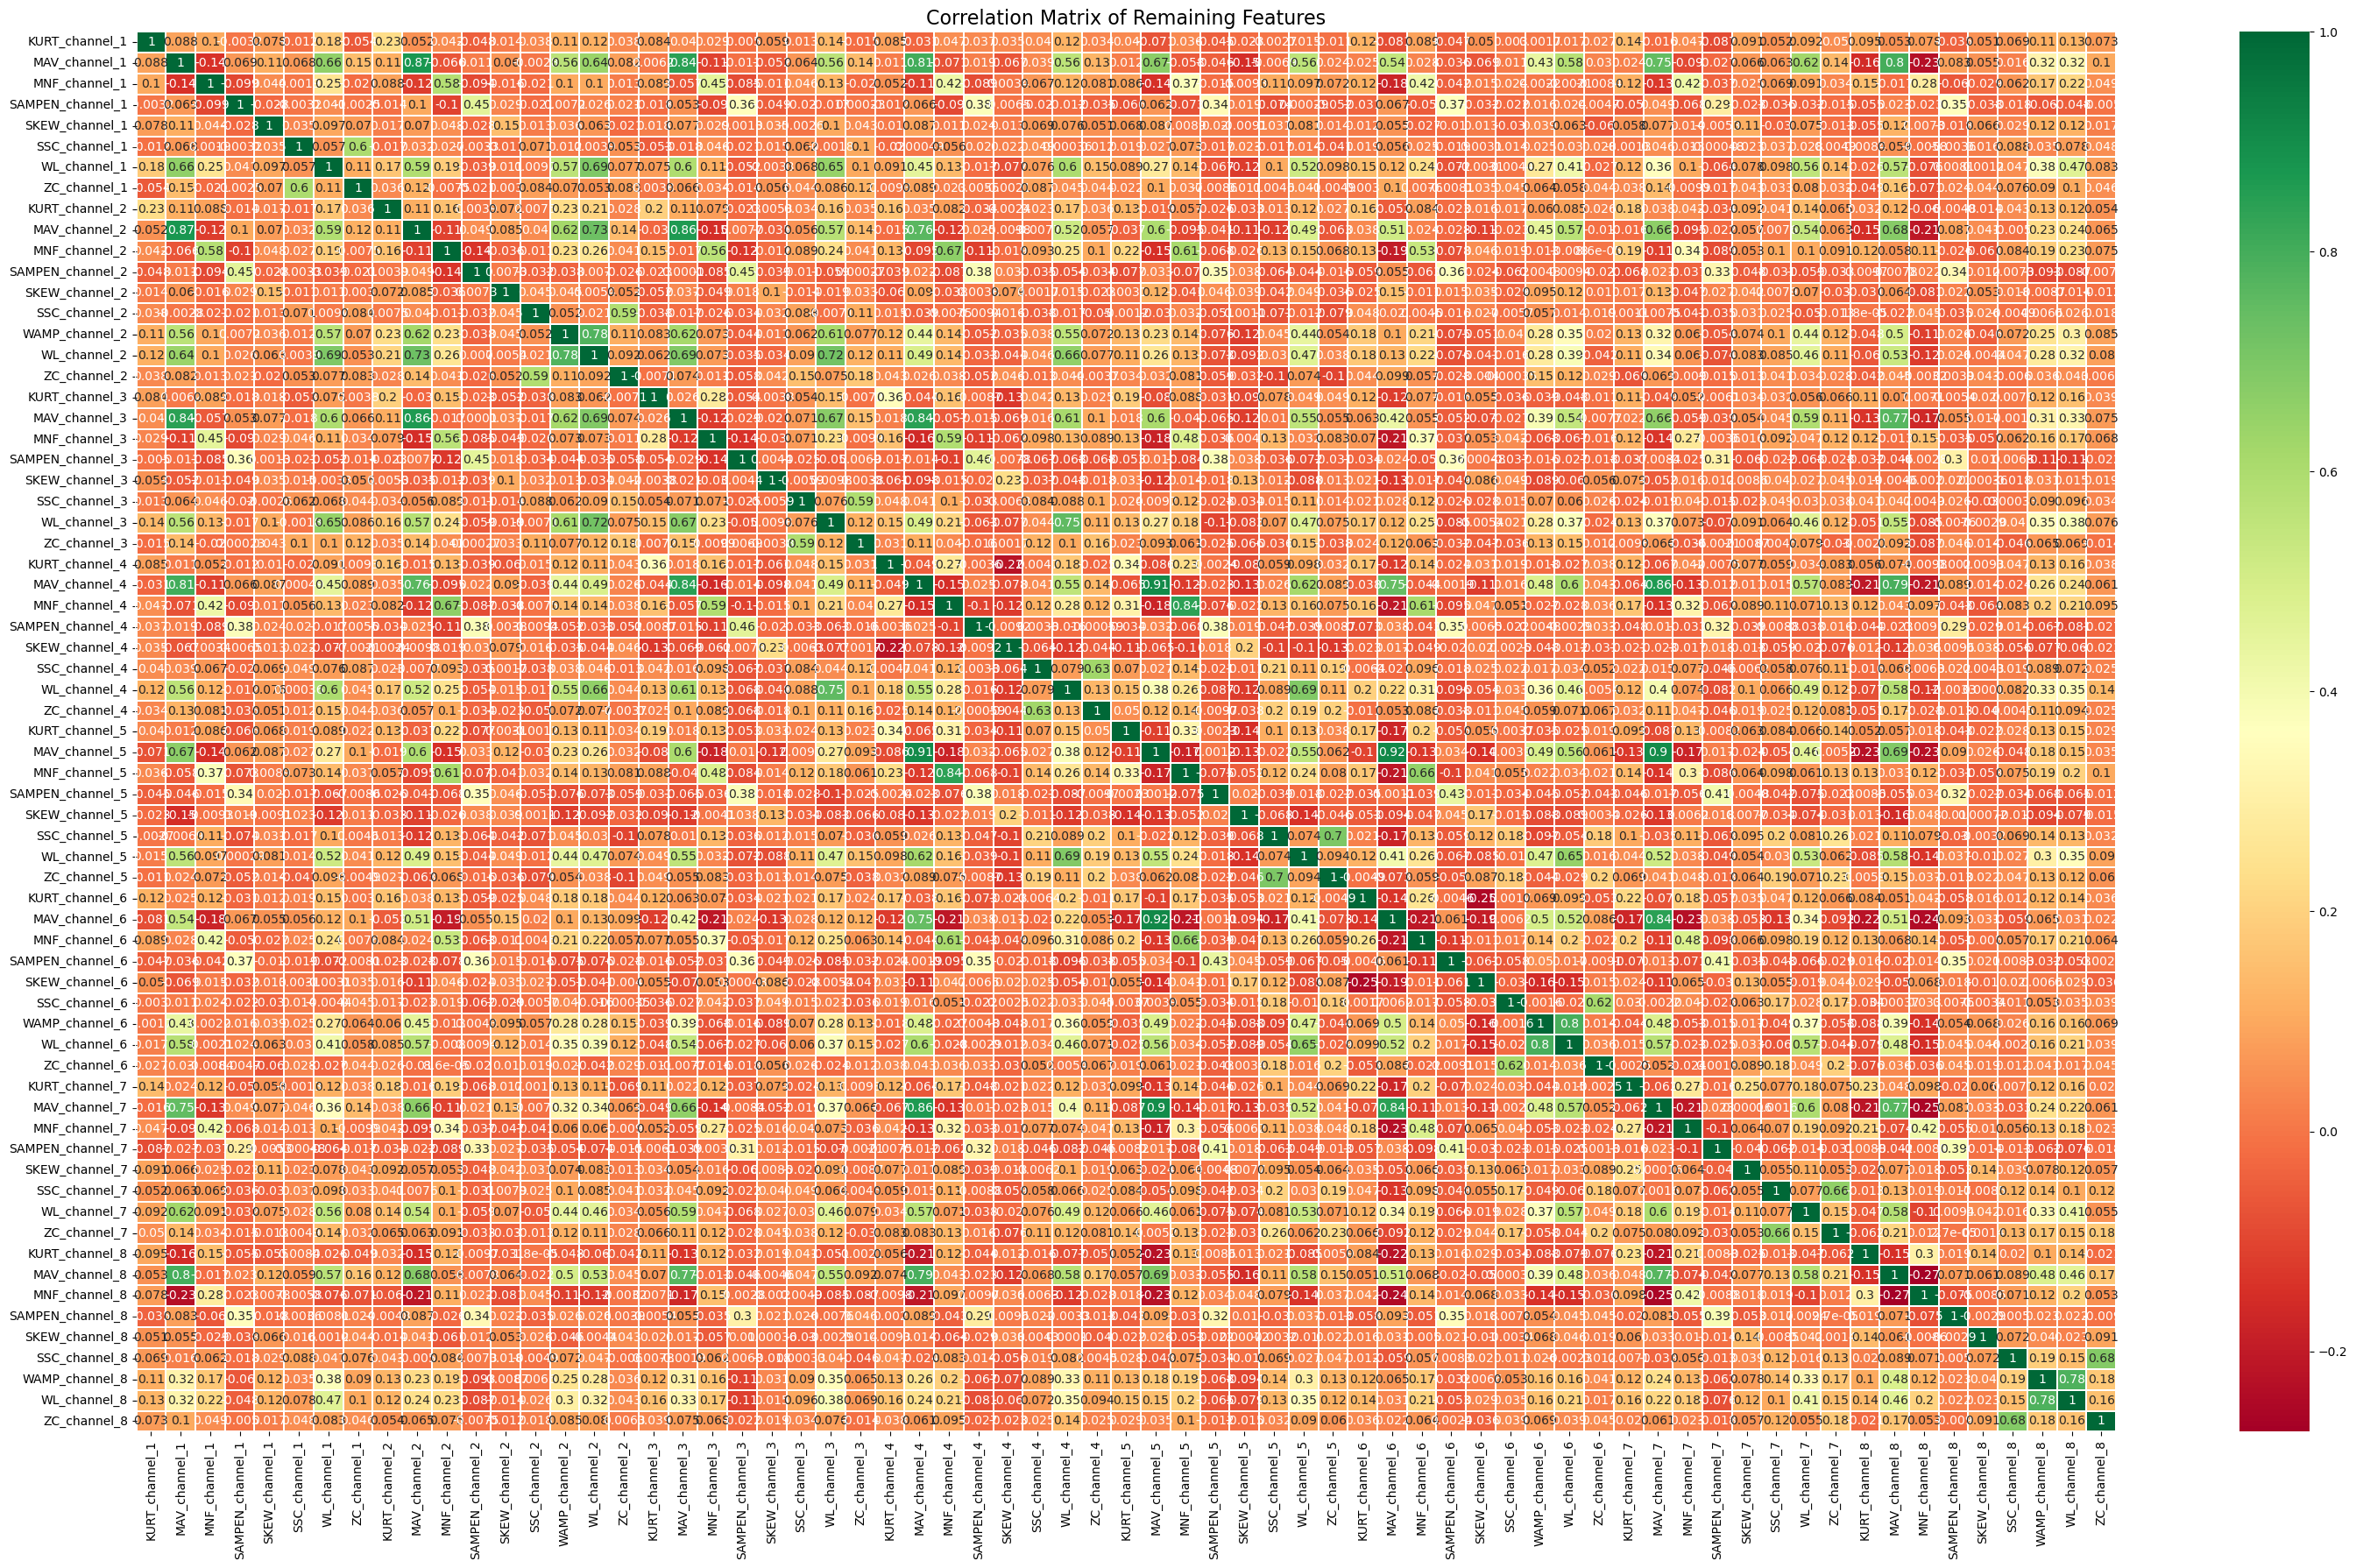

In [19]:
# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(30, 18))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', linewidths=0.3)

plt.title('Correlation Matrix of Remaining Features', fontsize=16)
plt.tight_layout()
plt.show()

## Feature Wrapping Selection (based on accuracy)

In [20]:
metric = "accuracy"
# Initialize the feature selector
n_samples = len(X)
fold_labels = np.arange(n_samples) % n_folds

np.random.seed(42) 
np.random.shuffle(fold_labels)

fold_labels = pd.Series(fold_labels)

crossvalidation_var = {
    "var": fold_labels,
    "crossval_amount": n_folds
}
data_dict = {col: X[[col]].values for col in X.columns}

In [ ]:
fs = FeatureSelector()
# Run feature selection
accuracy_results, accuracy_fs = fs.run_selection(data_dict, metric, y, crossvalidation_var)

# Print selected features
print("Features listed based on classification accuracy:")
print(accuracy_fs)

In [23]:
from sklearn.ensemble import RandomForestClassifier
for k in range(4, 35, 2): 
    features_k = accuracy_fs[:k]
    X_k = X[features_k]

    scores = cross_val_score(RandomForestClassifier(), X_k, y, cv=10)
    results.append((k, scores.mean()))

for k, acc in results:
    print(f"{k} features: Accuracy = {acc:.3f}")

4 features: Accuracy = 0.904
6 features: Accuracy = 0.916
8 features: Accuracy = 0.919
10 features: Accuracy = 0.923
12 features: Accuracy = 0.926
14 features: Accuracy = 0.924
16 features: Accuracy = 0.927
18 features: Accuracy = 0.928
20 features: Accuracy = 0.929
22 features: Accuracy = 0.928
24 features: Accuracy = 0.931
26 features: Accuracy = 0.932
28 features: Accuracy = 0.930
30 features: Accuracy = 0.930
32 features: Accuracy = 0.930
34 features: Accuracy = 0.929


# Model Training

In [24]:
X = X[accuracy_fs[:30]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)  # per cross_val_score e cross_val_predict

--------GaussianNB Naive Bayes -------
The accuracy Gaussian Naive Bayes Classifier is 83.5
The cross validated score for Gaussian Naive Bayes classifier is: 83.02


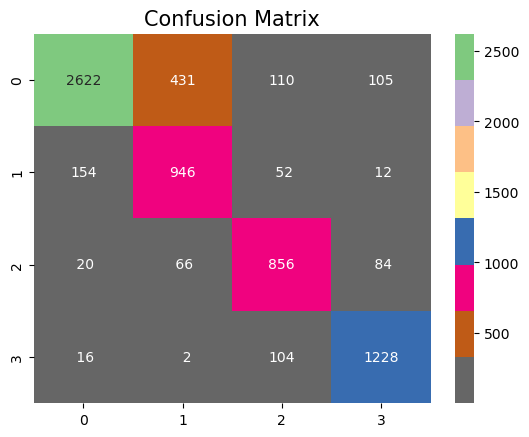

In [26]:
#################################### Naive Bayes ########################
from sklearn.naive_bayes import GaussianNB
model= GaussianNB()
model.fit(X_train,y_train)
prediction_gnb=model.predict(X_test)

print('--------GaussianNB Naive Bayes -------')
print('The accuracy Gaussian Naive Bayes Classifier is',round(accuracy_score(prediction_gnb,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True,random_state=42) # split the data into 10 equal parts

result_gnb=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for Gaussian Naive Bayes classifier is:',round(result_gnb.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

--------SVM -------
The accuracy SVM is 91.78
The cross validated score for SVM is: 92.17


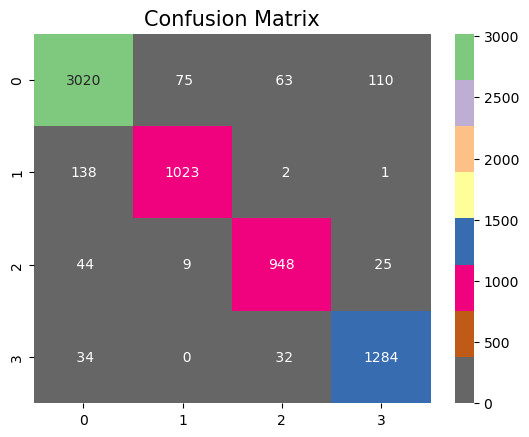

In [27]:
#################################### SVM ########################
from sklearn.svm import SVC, LinearSVC
model = SVC()
model.fit(X_train,y_train)
prediction_svm=model.predict(X_test)

print('--------SVM -------')
print('The accuracy SVM is',round(accuracy_score(prediction_svm,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True,random_state=42) # split the data into 10 equal parts

result_svm=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for SVM is:',round(result_svm.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

--------KNN -------
The accuracy KNN Classifier is 89.53
The cross validated score for KNN classifier is: 90.38


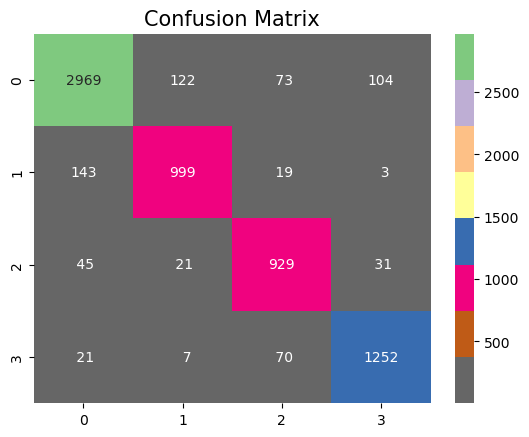

In [34]:
#################################### KNN ########################
from sklearn.neighbors import KNeighborsClassifier
model =  KNeighborsClassifier()
model.fit(X_train,y_train)
prediction_knn=model.predict(X_test)

print('--------KNN -------')
print('The accuracy KNN Classifier is',round(accuracy_score(prediction_knn,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True, random_state=42) 

result_knn=cross_val_score(model,X,y,cv=kfold,scoring='accuracy')

print('The cross validated score for KNN classifier is:',round(result_knn.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

--------Logistic Regression -------
The accuracy Logistic Regression is 89.87
The cross validated score for Logistic Regression is: 89.75


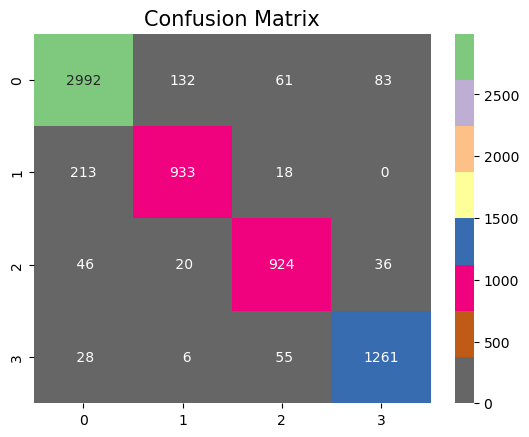

In [29]:
#################################### Logistic Regression ########################
from sklearn.linear_model import LogisticRegression
model =  LogisticRegression(max_iter=1000)

model.fit(X_train,y_train)
prediction_lr=model.predict(X_test)

print('--------Logistic Regression -------')
print('The accuracy Logistic Regression is',round(accuracy_score(prediction_lr,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True, random_state=42) # split the data into 10 equal parts

result_lr=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for Logistic Regression is:',round(result_lr.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

--------Random Forest Classifier -------
The accuracy Random Forest Classifier  is 93.29
The cross validated score for Random Forest Classifier is: 93.04


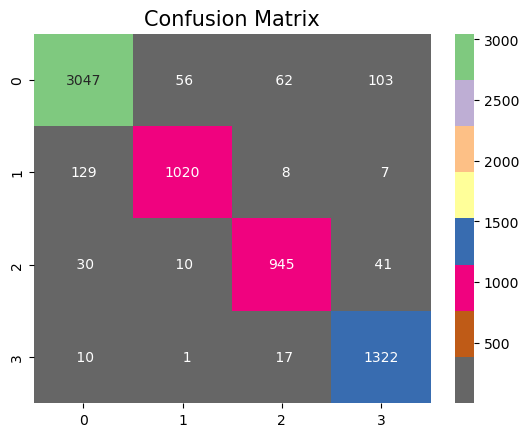

In [30]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=800,
                             min_samples_split=12,
                             max_features='sqrt',oob_score=True,
                             random_state=1,n_jobs=-1)

model.fit(X_train,y_train)
prediction_rf=model.predict(X_test)

print('--------Random Forest Classifier -------')
print('The accuracy Random Forest Classifier  is',round(accuracy_score(prediction_rf,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True, random_state=42) # split the data into 10 equal parts

result_rf=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for Random Forest Classifier is:',round(result_rf.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

-------- Gradient Boost -------
The accuracy Gradient Boost Classifier is 93.44
The cross validated score for Gradient Boost classifier is: 92.6


3

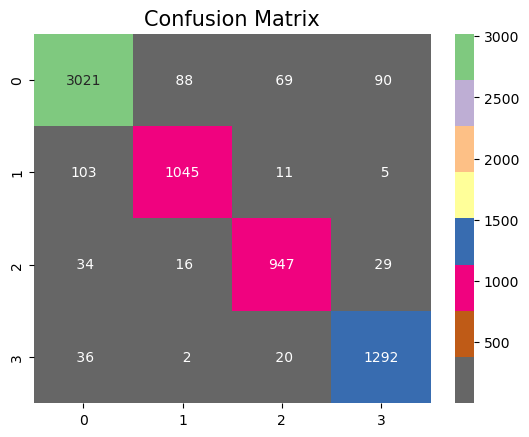

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier()

model.fit(X_train,y_train)
prediction_gb=model.predict(X_test)

print('-------- Gradient Boost -------')
print('The accuracy Gradient Boost Classifier is',round(accuracy_score(prediction_gb,y_test)*100,2))

kfold = KFold(n_splits=8, shuffle=True,random_state=42) # split the data into 10 equal parts

result_gb=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for Gradient Boost classifier is:',round(result_gb.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

--------ADA Boost -------
The accuracy ADA Boost Classifier is 60.89
The cross validated score for ADA Boost classifier is: 72.15


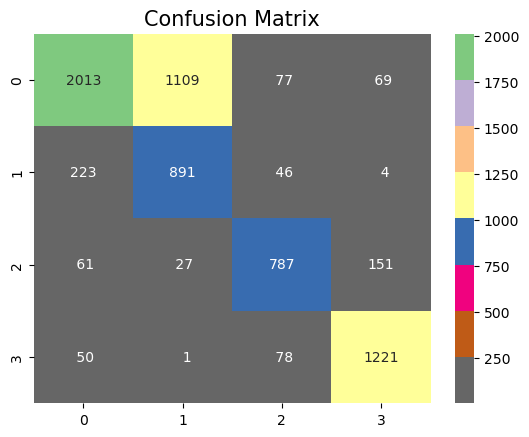

In [31]:
from sklearn.ensemble import AdaBoostClassifier
model= AdaBoostClassifier(algorithm='SAMME')

model.fit(X_train,y_train)
prediction_ada=model.predict(X_test)

print('--------ADA Boost -------')
print('The accuracy ADA Boost Classifier is',round(accuracy_score(prediction_ada,y_test)*100,2))

kfold = KFold(n_splits=8,shuffle=True, random_state=42) # split the data into 10 equal parts

result_ada=cross_val_score(model,X,y,cv=10,scoring='accuracy')

print('The cross validated score for ADA Boost classifier is:',round(result_ada.mean()*100,2))

y_pred = cross_val_predict(model,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="Accent_r")
plt.title('Confusion Matrix', y=1, size=15);

In [35]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'AdaBoostClassifier', 
              'Gradient Boosting'],
    'Score': [result_svm.mean(), result_knn.mean(), result_lr.mean(), 
              result_rf.mean(), result_gnb.mean(), result_ada.mean(), 
              result_gb.mean()]})
models.sort_values(by='Score',ascending=False)

Model     Score
3            Random Forest  0.930379
6        Gradient Boosting  0.925973
0  Support Vector Machines  0.921713
1                      KNN  0.903790
2      Logistic Regression  0.897478
4              Naive Bayes  0.830201
5       AdaBoostClassifier  0.721510